In [1]:
# Install required libraries (run this after restarting runtime)
!pip install kagglehub shap lime scikit-image tensorboard

# Captum requires CUDA dependencies and may trigger long install times
!pip install captum


!pip install numpy==2.0.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2d7750fbb247f6fd3d56442675de5d26caac86c901b143aaa9803d4ccfc4808a
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 102.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
captum 0.8.0 requires numpy<2.0, but you have numpy 2.0.0 which is incompatible.


KeyboardInterrupt: 

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                           precision_recall_fscore_support, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import glob
import json
from datetime import datetime
from tqdm import tqdm
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import kagglehub




from captum.attr import (
    IntegratedGradients,
    Saliency,
    LayerGradCam,
    GradientShap
)
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries, slic
import copy

from captum.attr import visualization as viz
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries  # Add this for LIME visualization

# Optional imports for logging
try:
    from torch.utils.tensorboard import SummaryWriter
    TENSORBOARD_AVAILABLE = True
except ImportError:
    TENSORBOARD_AVAILABLE = False
    print("tensorboard not available. Install with: pip install tensorboard")


In [4]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Download dataset
path = kagglehub.dataset_download("ambarish/breakhis")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/breakhis


In [6]:
class LabelSmoothingCrossEntropy(nn.Module):
    """Label Smoothing Cross Entropy Loss"""
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        confidence = 1. - self.smoothing
        log_probs = torch.log_softmax(pred, dim=1)
        nll_loss = -log_probs.gather(dim=1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -log_probs.mean(dim=1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [7]:
class RandAugment:
    """RandAugment implementation"""
    def __init__(self, n=2, m=10):
        self.n = n
        self.m = m
        self.augmentations = [
            self.auto_contrast,
            self.equalize,
            self.rotate,
            self.solarize,
            self.color,
            self.posterize,
            self.contrast,
            self.brightness,
            self.sharpness,
            self.shear_x,
            self.shear_y,
            self.translate_x,
            self.translate_y,
        ]

    def __call__(self, img):
        ops = np.random.choice(self.augmentations, self.n, replace=False)
        for op in ops:
            img = op(img)
        return img

    def auto_contrast(self, img):
        return transforms.functional.autocontrast(img)

    def equalize(self, img):
        return transforms.functional.equalize(img)

    def rotate(self, img):
        angle = (self.m / 30) * 30 * np.random.choice([-1, 1])
        return transforms.functional.rotate(img, angle)

    def solarize(self, img):
        return transforms.functional.solarize(img, int(256 * (1 - self.m / 10)))

    def color(self, img):
        factor = 1 + (self.m / 10) * np.random.choice([-1, 1])
        return transforms.functional.adjust_saturation(img, factor)

    def posterize(self, img):
        bits = int(8 - (self.m / 10) * 4)
        return transforms.functional.posterize(img, bits)

    def contrast(self, img):
        factor = 1 + (self.m / 10) * np.random.choice([-1, 1])
        return transforms.functional.adjust_contrast(img, factor)

    def brightness(self, img):
        factor = 1 + (self.m / 10) * np.random.choice([-1, 1])
        return transforms.functional.adjust_brightness(img, factor)

    def sharpness(self, img):
        factor = 1 + (self.m / 10) * np.random.choice([-1, 1])
        return transforms.functional.adjust_sharpness(img, factor)

    def shear_x(self, img):
        shear = (self.m / 10) * 0.3 * np.random.choice([-1, 1])
        return transforms.functional.affine(img, angle=0, translate=(0, 0), scale=1, shear=(shear, 0))

    def shear_y(self, img):
        shear = (self.m / 10) * 0.3 * np.random.choice([-1, 1])
        return transforms.functional.affine(img, angle=0, translate=(0, 0), scale=1, shear=(0, shear))

    def translate_x(self, img):
        translate = int((self.m / 10) * 0.3 * img.size[0]) * np.random.choice([-1, 1])
        return transforms.functional.affine(img, angle=0, translate=(translate, 0), scale=1, shear=(0, 0))

    def translate_y(self, img):
        translate = int((self.m / 10) * 0.3 * img.size[1]) * np.random.choice([-1, 1])
        return transforms.functional.affine(img, angle=0, translate=(0, translate), scale=1, shear=(0, 0))


In [8]:
class BreaKHisDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
def load_dataset(dataset_path):
    """Load and organize the BreaKHis dataset"""
    image_paths = []
    labels = []
    magnifications = []
    patient_ids = []

    # Use glob to find all PNG files recursively
    breast_img_paths = glob.glob(os.path.join(dataset_path, 'BreaKHis_v1/BreaKHis_v1/histology_slides/breast/**/*.png'), recursive=True)

    print(f"Found {len(breast_img_paths)} image files")

    for img_path in breast_img_paths:
        try:
            # Extract information from path
            path_parts = img_path.split(os.sep)

            # Find benign/malignant classification from path
            if 'benign' in img_path.lower():
                label = 0  # benign
            elif 'malignant' in img_path.lower():
                label = 1  # malignant
            else:
                continue

            # Extract filename for further processing
            filename = os.path.basename(img_path)

            # Extract magnification from filename (format: SOB_B_A-14-22549AB-40-001.png)
            if '-40-' in filename:
                mag = '40X'
            elif '-100-' in filename:
                mag = '100X'
            elif '-200-' in filename:
                mag = '200X'
            elif '-400-' in filename:
                mag = '400X'
            else:
                continue

            # Extract patient ID from filename (format: SOB_B_A-14-22549AB-40-001.png)
            # Patient ID is the part before the magnification
            parts = filename.split('-')
            if len(parts) >= 3:
                patient_id = '-'.join(parts[:3])  # SOB_B_A-14-22549AB
            else:
                patient_id = filename.split('.')[0]

            image_paths.append(img_path)
            labels.append(label)
            magnifications.append(mag)
            patient_ids.append(patient_id)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels,
        'magnification': magnifications,
        'patient_id': patient_ids
    })

    print(f"Successfully loaded {len(df)} images")
    print(f"Benign: {len(df[df['label'] == 0])}, Malignant: {len(df[df['label'] == 1])}")

    return df


In [10]:
def create_patient_level_split(df, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """Split dataset at patient level to avoid data leakage"""
    unique_patients = df['patient_id'].unique()

    # Split patients first
    train_patients, temp_patients = train_test_split(
        unique_patients, test_size=(val_ratio + test_ratio), random_state=42, stratify=None
    )
    val_patients, test_patients = train_test_split(
        temp_patients, test_size=test_ratio/(val_ratio + test_ratio), random_state=42, stratify=None
    )

    # Create splits ensuring no patient overlap
    train_df = df[df['patient_id'].isin(train_patients)].copy()
    val_df = df[df['patient_id'].isin(val_patients)].copy()
    test_df = df[df['patient_id'].isin(test_patients)].copy()

    # Verify no patient overlap
    train_patients_set = set(train_df['patient_id'].unique())
    val_patients_set = set(val_df['patient_id'].unique())
    test_patients_set = set(test_df['patient_id'].unique())

    assert len(train_patients_set.intersection(val_patients_set)) == 0, "Patient overlap between train and val"
    assert len(train_patients_set.intersection(test_patients_set)) == 0, "Patient overlap between train and test"
    assert len(val_patients_set.intersection(test_patients_set)) == 0, "Patient overlap between val and test"

    print(f"Patient-level split verified:")
    print(f"Train patients: {len(train_patients_set)}")
    print(f"Val patients: {len(val_patients_set)}")
    print(f"Test patients: {len(test_patients_set)}")

    return train_df, val_df, test_df

In [11]:
def get_transforms():
    """Define improved data augmentation and preprocessing transforms with RandAugment"""

    # Training transforms with RandAugment
    train_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        RandAugment(n=2, m=10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Validation/Test transforms (no augmentation)
    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # TTA transforms for test time augmentation
    tta_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transforms, val_transforms, tta_transforms

In [12]:
def create_balanced_sampler(labels):
    """Create weighted sampler for handling class imbalance"""
    class_counts = Counter(labels)
    class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in labels]

    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )


In [13]:
def create_resnet_model(num_classes=2, dropout_rate=0.5):
    """Create ResNet-50 model with enhanced classifier head"""
    model = models.resnet50(pretrained=True)

    # Initially freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Enhanced classifier head
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(512, num_classes)
    )

    return model

In [14]:
def set_differential_learning_rates(model, base_lr=1e-4):
    """Set different learning rates for different layer groups"""
    parameters = [
        {'params': model.conv1.parameters(), 'lr': base_lr * 0.1},
        {'params': model.bn1.parameters(), 'lr': base_lr * 0.1},
        {'params': model.layer1.parameters(), 'lr': base_lr * 0.2},
        {'params': model.layer2.parameters(), 'lr': base_lr * 0.4},
        {'params': model.layer3.parameters(), 'lr': base_lr * 0.8},
        {'params': model.layer4.parameters(), 'lr': base_lr},
        {'params': model.fc.parameters(), 'lr': base_lr * 2},
    ]
    return parameters

In [15]:
def unfreeze_layers(model, epoch):
    """Gradually unfreeze layers"""
    if epoch >= 5:
        # Unfreeze layer4 and layer3
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.layer3.parameters():
            param.requires_grad = True

    if epoch >= 10:
        # Unfreeze layer2 and layer1
        for param in model.layer2.parameters():
            param.requires_grad = True
        for param in model.layer1.parameters():
            param.requires_grad = True
        for param in model.conv1.parameters():
            param.requires_grad = True
        for param in model.bn1.parameters():
            param.requires_grad = True

In [16]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=1e-4,
                use_mixed_precision=True, logger=None, magnification=None, save_dir='./models/'):
    """Enhanced training with differential learning rates and gradual unfreezing"""

    os.makedirs(save_dir, exist_ok=True)
    model_name = f"resnet50_{magnification if magnification else 'all'}.pth"
    best_model_path = os.path.join(save_dir, f"best_{model_name}")

    model = model.to(device)

    # Loss function with label smoothing
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

    # Optimizer with differential learning rates
    param_groups = set_differential_learning_rates(model, learning_rate)
    optimizer = optim.AdamW(param_groups, weight_decay=0.01)

    # Cosine Annealing Warm Restarts scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )

    # Mixed precision training
    if use_mixed_precision and torch.cuda.is_available():
        scaler = torch.cuda.amp.GradScaler()
    else:
        scaler = None

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    val_f1_scores = []

    best_val_f1 = 0.0
    patience = 15
    patience_counter = 0

    for epoch in range(num_epochs):
        # Gradual unfreezing
        unfreeze_layers(model, epoch)

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for batch_idx, (images, labels) in enumerate(train_pbar):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100 * train_correct / train_total:.2f}%'
            })

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)

                if scaler:
                    with torch.cuda.amp.autocast():
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_predictions.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100 * val_correct / val_total:.2f}%'
                })

        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        # Calculate F1 score
        _, _, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}')
        print(f'Current LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 50)

        # Log to tensorboard if available
        if logger and logger['type'] == 'tensorboard':
            logger['logger'].add_scalar('Loss/Train', train_loss, epoch)
            logger['logger'].add_scalar('Loss/Val', val_loss, epoch)
            logger['logger'].add_scalar('Accuracy/Train', train_acc, epoch)
            logger['logger'].add_scalar('Accuracy/Val', val_acc, epoch)
            logger['logger'].add_scalar('F1/Val', val_f1, epoch)
            logger['logger'].add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], epoch)

        # Step scheduler
        scheduler.step()

        # Early stopping based on validation F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with F1: {best_val_f1:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    return model, train_losses, val_losses, train_accuracies, val_accuracies, val_f1_scores


In [17]:
def test_time_augmentation(model, dataset, num_augmentations=5):
    """Perform test time augmentation"""
    model.eval()

    # Get original transform
    original_transform = dataset.transform

    # TTA transforms
    _, _, tta_transforms = get_transforms()

    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for idx in tqdm(range(len(dataset)), desc='TTA Evaluation'):
            image_path = dataset.image_paths[idx]
            label = dataset.labels[idx]

            # Load image
            image = Image.open(image_path).convert('RGB')

            # Collect predictions from multiple augmentations
            aug_predictions = []
            aug_probabilities = []

            for _ in range(num_augmentations):
                # Apply TTA transform
                augmented_image = tta_transforms(image)
                augmented_image = augmented_image.unsqueeze(0).to(device)

                # Get prediction
                outputs = model(augmented_image)
                probabilities = torch.softmax(outputs, dim=1)

                aug_predictions.append(outputs.cpu().numpy())
                aug_probabilities.append(probabilities.cpu().numpy())

            # Average predictions
            avg_outputs = np.mean(aug_predictions, axis=0)
            avg_probabilities = np.mean(aug_probabilities, axis=0)

            predicted = np.argmax(avg_outputs, axis=1)[0]

            all_predictions.append(predicted)
            all_labels.append(label)
            all_probabilities.append(avg_probabilities[0][1])  # Probability of malignant class

    return all_labels, all_predictions, all_probabilities

In [18]:
def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    """Calculate comprehensive metrics including specificity and AUC-ROC"""
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    # Confusion matrix for specificity calculation
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # AUC-ROC (if probabilities provided)
    auc_roc = None
    if y_pred_proba is not None:
        auc_roc = roc_auc_score(y_true, y_pred_proba)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'auc_roc': auc_roc,
        'confusion_matrix': cm,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

In [19]:
def evaluate_model(model, test_loader, class_names=['Benign', 'Malignant'], use_tta=True):
    """Evaluate model with optional TTA"""
    if use_tta:
        print("Performing Test Time Augmentation...")
        all_labels, all_predictions, all_probabilities = test_time_augmentation(
            model, test_loader.dataset, num_augmentations=5
        )
    else:
        model.eval()
        all_predictions = []
        all_labels = []
        all_probabilities = []

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc='Evaluating'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probabilities.extend(probabilities[:, 1].cpu().numpy())

    # Calculate comprehensive metrics
    metrics = calculate_metrics(all_labels, all_predictions, all_probabilities)

    # Classification report
    report = classification_report(all_labels, all_predictions, target_names=class_names)

    metrics['classification_report'] = report
    metrics['predictions'] = all_predictions
    metrics['labels'] = all_labels
    metrics['probabilities'] = all_probabilities

    return metrics


In [20]:
def plot_confusion_matrix(cm, class_names, title, save_path=None):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [21]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies,
                        val_f1_scores=None, save_path=None):
    """Plot training and validation curves"""
    fig, axes = plt.subplots(1, 3 if val_f1_scores else 2, figsize=(20, 5))

    # Loss curves
    axes[0].plot(train_losses, label='Training Loss')
    axes[0].plot(val_losses, label='Validation Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy curves
    axes[1].plot(train_accuracies, label='Training Accuracy')
    axes[1].plot(val_accuracies, label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)

    # F1 score curves
    if val_f1_scores:
        axes[2].plot(val_f1_scores, label='Validation F1 Score', color='green')
        axes[2].set_title('Validation F1 Score')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('F1 Score')
        axes[2].legend()
        axes[2].grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [22]:
def plot_roc_curve(labels, probabilities, title='ROC Curve', save_path=None):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(labels, probabilities)
    auc_score = roc_auc_score(labels, probabilities)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [23]:
def plot_percentage_recall_curve(labels, probabilities, save_path=None):
    """Plot percentage recall curve showing recall at different confidence thresholds"""
    # Calculate recall at different thresholds
    thresholds = np.linspace(0, 1, 100)
    recalls = []
    precisions = []

    for threshold in thresholds:
        pred_binary = (probabilities >= threshold).astype(int)
        if len(np.unique(pred_binary)) > 1:  # Avoid division by zero
            precision, recall, _, _ = precision_recall_fscore_support(
                labels, pred_binary, average='binary', zero_division=0
            )
            recalls.append(recall * 100)  # Convert to percentage
            precisions.append(precision * 100)
        else:
            recalls.append(0)
            precisions.append(0)

    # Class distribution
    class_counts = np.bincount(labels)
    class_percentages = (class_counts / len(labels)) * 100

    # Create plot
    plt.figure(figsize=(10, 6))

    # Plot recall curve
    plt.plot(thresholds, recalls, label='Recall (%)', color='blue', linewidth=2)

    # Plot precision curve
    plt.plot(thresholds, precisions, label='Precision (%)', color='green', linewidth=2)

    # Add class distribution information
    plt.axhline(y=class_percentages[1], color='red', linestyle='--',
                label=f'Malignant Prevalence ({class_percentages[1]:.1f}%)')
    plt.axhline(y=class_percentages[0], color='orange', linestyle='--',
                label=f'Benign Prevalence ({class_percentages[0]:.1f}%)')

    # Add optimal threshold point (Youden's J statistic)
    fpr, tpr, thresh = roc_curve(labels, probabilities)
    youden_idx = np.argmax(tpr - fpr)
    optimal_thresh = thresh[youden_idx]

    # Find recall and precision at optimal threshold
    opt_recall = recalls[np.abs(thresholds - optimal_thresh).argmin()]
    opt_precision = precisions[np.abs(thresholds - optimal_thresh).argmin()]

    plt.scatter(optimal_thresh, opt_recall, color='blue', s=100,
                label=f'Optimal Threshold ({optimal_thresh:.2f})')
    plt.scatter(optimal_thresh, opt_precision, color='green', s=100)

    # Plot styling
    plt.title('Percentage Recall and Precision Curve')
    plt.xlabel('Classification Threshold')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 105)
    plt.xlim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Add text box with optimal threshold info
    textstr = '\n'.join((
        f'Optimal Threshold: {optimal_thresh:.3f}',
        f'Recall at Optimal: {opt_recall:.1f}%',
        f'Precision at Optimal: {opt_precision:.1f}%'
    ))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(1.05, 0.95, textstr, transform=plt.gca().transAxes,
             verticalalignment='top', bbox=props)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


In [24]:
def display_metrics(metrics, class_names=['Benign', 'Malignant']):
    """Display all evaluation metrics in a formatted way"""
    print("\n" + "="*50)
    print("Evaluation Metrics")
    print("="*50)
    print(f"Accuracy:    {metrics['accuracy']:.4f}")
    print(f"Precision:   {metrics['precision']:.4f}")
    print(f"Recall:      {metrics['recall']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print(f"F1 Score:    {metrics['f1']:.4f}")
    print(f"AUC-ROC:     {metrics['auc_roc']:.4f}")

    print("\nConfusion Matrix:")
    cm_df = pd.DataFrame(metrics['confusion_matrix'],
                        index=class_names,
                        columns=class_names)
    print(cm_df)

    print("\nClassification Report:")
    print(metrics['classification_report'])


In [25]:
def generate_all_plots(metrics, train_losses, val_losses, train_accuracies, val_accuracies, val_f1_scores=None):
    """Generate all required plots"""
    # Create directory for plots
    os.makedirs('plots', exist_ok=True)

    # Training curves
    plot_training_curves(
        train_losses, val_losses, train_accuracies, val_accuracies, val_f1_scores,
        save_path='plots/training_curves.png'
    )

    # Confusion matrix
    plot_confusion_matrix(
        metrics['confusion_matrix'],
        class_names=['Benign', 'Malignant'],
        title='Confusion Matrix',
        save_path='plots/confusion_matrix.png'
    )

    # ROC curve
    plot_roc_curve(
        metrics['labels'],
        metrics['probabilities'],
        title='ROC Curve',
        save_path='plots/roc_curve.png'
    )

    # Percentage recall curve
    plot_percentage_recall_curve(
        metrics['labels'],
        metrics['probabilities'],
        save_path='plots/percentage_recall.png'
    )

In [26]:
def fix_model_inplace_operations(model):
    """Fix in-place operations in the model for XAI compatibility"""
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            module.inplace = False
        elif isinstance(module, nn.BatchNorm2d):
            # Some batch norm layers might have in-place operations
            pass
    return model

In [27]:
def create_xai_compatible_model(original_model):
    """Create a model compatible with all XAI techniques"""
    class XAIModel(nn.Module):
        def __init__(self, base_model):
            super(XAIModel, self).__init__()
            # Create a deep copy to avoid modifying the original
            self.base_model = copy.deepcopy(base_model)

            # Fix all inplace operations
            self._fix_inplace_operations(self.base_model)

        def _fix_inplace_operations(self, module):
            """Recursively fix all inplace operations in the model"""
            for name, child in module.named_children():
                if isinstance(child, nn.ReLU):
                    setattr(module, name, nn.ReLU(inplace=False))
                elif isinstance(child, nn.LeakyReLU):
                    setattr(module, name, nn.LeakyReLU(inplace=False))
                elif isinstance(child, nn.ELU):
                    setattr(module, name, nn.ELU(inplace=False))
                else:
                    self._fix_inplace_operations(child)

        def forward(self, x):
            # Ensure input requires gradients and clone to avoid inplace issues
            if x.requires_grad:
                x = x.clone()
            return self.base_model(x)

        # Provide access to layers for GradCAM
        @property
        def layer4(self):
            return self.base_model.layer4

        @property
        def conv1(self):
            return self.base_model.conv1

        @property
        def layer1(self):
            return self.base_model.layer1

        @property
        def layer2(self):
            return self.base_model.layer2

        @property
        def layer3(self):
            return self.base_model.layer3

        @property
        def avgpool(self):
            return self.base_model.avgpool

        @property
        def fc(self):
            return self.base_model.fc

    return XAIModel(original_model)

In [28]:
def preprocess_image_for_visualization(images_tensor, mean, std):
    """Convert tensor to numpy and denormalize for visualization"""
    # Clone to avoid modifying original tensor
    images_np = images_tensor.clone().cpu().detach().numpy()

    if images_np.ndim == 4:  # Batch dimension
        images_np = np.transpose(images_np, (0, 2, 3, 1))
    else:  # Single image
        images_np = np.transpose(images_np, (1, 2, 0))

    # Denormalize
    images_np = std * images_np + mean
    images_np = np.clip(images_np, 0, 1)
    return images_np

In [29]:
def compute_saliency(model, input_tensor, target_class):
    """Compute saliency maps with proper gradient handling"""
    try:
        saliency = Saliency(model)
        # Clone input and ensure it requires gradients
        input_for_grad = input_tensor.clone().detach().requires_grad_(True)

        attribution = saliency.attribute(input_for_grad, target=target_class)
        attribution = attribution.squeeze().cpu().detach().numpy()

        # Convert to grayscale if needed
        if attribution.ndim == 3:
            attribution = np.mean(np.abs(attribution), axis=0)

        return attribution
    except Exception as e:
        print(f"Saliency computation failed: {e}")
        return None

In [30]:
def compute_gradcam(model, input_tensor, target_class):
    """Compute Grad-CAM with proper layer selection"""
    try:
        # Find the last convolutional layer in layer4
        target_layer = None
        for name, module in model.named_modules():
            if 'layer4' in name and isinstance(module, nn.Conv2d):
                target_layer = module

        if target_layer is None:
            # Fallback to layer4 itself
            target_layer = model.layer4

        grad_cam = LayerGradCam(model, target_layer)
        # Clone input to avoid inplace issues
        input_for_grad = input_tensor.clone().detach().requires_grad_(True)

        attribution = grad_cam.attribute(input_for_grad, target=target_class)
        attribution = attribution.squeeze().cpu().detach().numpy()

        # Ensure 2D output
        while attribution.ndim > 2:
            attribution = np.mean(attribution, axis=0)

        return attribution
    except Exception as e:
        print(f"Grad-CAM computation failed: {e}")
        return None

In [31]:
def compute_integrated_gradients(model, input_tensor, target_class, baseline=None):
    """Compute Integrated Gradients with proper baseline handling"""
    try:
        ig = IntegratedGradients(model)
        # Clone input to avoid inplace issues
        input_for_grad = input_tensor.clone().detach().requires_grad_(True)

        if baseline is None:
            baseline = torch.zeros_like(input_for_grad)

        attribution = ig.attribute(
            input_for_grad,
            baselines=baseline,
            target=target_class,
            n_steps=50
        )
        attribution = attribution.squeeze().cpu().detach().numpy()

        # Convert to grayscale if needed
        if attribution.ndim == 3:
            attribution = np.mean(np.abs(attribution), axis=0)

        return attribution
    except Exception as e:
        print(f"Integrated Gradients computation failed: {e}")
        return None

In [32]:
def compute_shap(model, input_tensor, background_tensor, target_class):
    """Compute SHAP values using GradientShap"""
    try:
        gradient_shap = GradientShap(model)
        # Clone inputs to avoid inplace issues
        input_for_grad = input_tensor.clone().detach().requires_grad_(True)

        # Create random baselines from background
        n_samples = min(5, len(background_tensor))
        baselines = background_tensor[:n_samples].clone().detach().requires_grad_(True)

        attribution = gradient_shap.attribute(
            input_for_grad,
            baselines=baselines,
            target=target_class,
            n_samples=20
        )
        attribution = attribution.squeeze().cpu().detach().numpy()

        # Convert to grayscale if needed
        if attribution.ndim == 3:
            attribution = np.mean(np.abs(attribution), axis=0)

        return attribution

    except Exception as e:
        print(f"SHAP computation failed: {e}")
        return None

In [33]:
def compute_lime(model, input_image_np, target_class, mean, std, device):
    """Compute LIME explanation with proper setup"""
    try:
        from lime import lime_image
        explainer = lime_image.LimeImageExplainer()

        def predict_fn(images):
            """Prediction function for LIME"""
            if len(images) == 0:
                return np.array([])

            batch_tensors = []

            for img in images:
                # Normalize the image
                img_normalized = (img - mean) / std
                img_tensor = torch.FloatTensor(img_normalized).permute(2, 0, 1).unsqueeze(0).to(device)
                batch_tensors.append(img_tensor)

            if batch_tensors:
                batch_tensor = torch.cat(batch_tensors, dim=0)

                with torch.no_grad():
                    outputs = model(batch_tensor)
                    probabilities = torch.softmax(outputs, dim=1)
                    return probabilities.cpu().numpy()
            else:
                return np.array([])

        # Generate explanation
        explanation = explainer.explain_instance(
            input_image_np,
            predict_fn,
            top_labels=2,
            hide_color=0,
            num_samples=500,  # Reduced for faster computation
            segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10, sigma=1)
        )

        # Get mask and score
        mask, score = explanation.get_image_and_mask(
            target_class,
            positive_only=False,
            num_features=10,
            hide_rest=False
        )

        return mask, score

    except Exception as e:
        print(f"LIME computation failed: {e}")
        return None, None


In [34]:
def safe_numpy_conversion(tensor_data):
    """Safely convert tensor to numpy with proper data type handling"""
    if isinstance(tensor_data, torch.Tensor):
        numpy_data = tensor_data.cpu().detach().numpy()
    else:
        numpy_data = np.array(tensor_data)

    # Ensure proper data type for visualization
    if numpy_data.dtype == np.float64:
        numpy_data = numpy_data.astype(np.float32)
    elif numpy_data.dtype not in [np.uint8, np.float32, np.float64]:
        numpy_data = numpy_data.astype(np.float32)

    return numpy_data

In [35]:
def fixed_preprocess_image_for_visualization(images_tensor, mean, std):
    """Fixed image preprocessing with proper data type handling"""
    # Clone to avoid modifying original tensor
    images_np = safe_numpy_conversion(images_tensor)

    if images_np.ndim == 4:  # Batch dimension
        images_np = np.transpose(images_np, (0, 2, 3, 1))
    else:  # Single image
        images_np = np.transpose(images_np, (1, 2, 0))

    # Ensure mean and std are numpy arrays with correct shape
    mean = np.array(mean, dtype=np.float32)
    std = np.array(std, dtype=np.float32)

    # Denormalize
    images_np = std * images_np + mean
    images_np = np.clip(images_np, 0, 1)

    return images_np.astype(np.float32)

In [36]:
def fixed_compute_lime(model, input_image_np, target_class, mean, std, device):
    """Fixed LIME computation with proper data type handling"""
    try:
        from lime import lime_image
        from skimage.segmentation import slic

        explainer = lime_image.LimeImageExplainer()

        # Ensure input image has correct data type
        input_image_np = input_image_np.astype(np.float32)
        mean = np.array(mean, dtype=np.float32)
        std = np.array(std, dtype=np.float32)

        def predict_fn(images):
            """Prediction function for LIME with fixed data types"""
            if len(images) == 0:
                return np.array([])

            batch_tensors = []

            for img in images:
                # Ensure image is float32
                img = img.astype(np.float32)

                # Normalize the image
                img_normalized = (img - mean) / std
                img_tensor = torch.FloatTensor(img_normalized).permute(2, 0, 1).unsqueeze(0).to(device)
                batch_tensors.append(img_tensor)

            if batch_tensors:
                batch_tensor = torch.cat(batch_tensors, dim=0)

                with torch.no_grad():
                    outputs = model(batch_tensor)
                    probabilities = torch.softmax(outputs, dim=1)
                    return probabilities.cpu().numpy().astype(np.float32)
            else:
                return np.array([])

        # Generate explanation with reduced samples for stability
        explanation = explainer.explain_instance(
            input_image_np,
            predict_fn,
            top_labels=2,
            hide_color=0,
            num_samples=300,  # Reduced for stability
            segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10, sigma=1, start_label=0)
        )

        # Get mask and score
        mask, score = explanation.get_image_and_mask(
            target_class,
            positive_only=False,
            num_features=10,
            hide_rest=False
        )

        # Ensure mask is proper data type
        mask = mask.astype(np.float32)

        return mask, float(score)

    except Exception as e:
        print(f"LIME computation failed: {e}")
        return None, None


In [37]:
# Missing XAI visualization function
def visualize_all_xai_techniques(model, test_loader, device, num_samples=3):
    """
    Comprehensive XAI visualization using multiple explanation techniques
    """
    print("Creating XAI-compatible model...")
    xai_model = create_xai_compatible_model(model)
    xai_model = xai_model.to(device)
    xai_model.eval()

    # Get test samples
    images, labels = next(iter(test_loader))
    images = images[:num_samples].to(device)
    labels = labels[:num_samples].to(device)

    # Get predictions
    with torch.no_grad():
        outputs = xai_model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)

    # Preprocessing constants
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    # Convert images for visualization
    images_np = fixed_preprocess_image_for_visualization(images, mean, std)

    # Create background for SHAP
    background_loader = torch.utils.data.DataLoader(test_loader.dataset, batch_size=10, shuffle=True)
    background_images, _ = next(iter(background_loader))
    background_images = background_images.to(device)

    for i in range(num_samples):
        print(f"\n{'='*60}")
        print(f"Processing Sample {i+1}")
        print(f"True Label: {'Malignant' if labels[i].item() == 1 else 'Benign'}")
        print(f"Predicted: {'Malignant' if predictions[i].item() == 1 else 'Benign'}")
        print(f"Confidence: {probabilities[i][predictions[i]].item():.4f}")
        print(f"{'='*60}")

        input_tensor = images[i].unsqueeze(0)
        target_class = predictions[i].item()
        input_image_np = images_np[i]

        # Initialize results dictionary
        results = {}

        # 1. Saliency Map
        print("Computing Saliency Map...")
        try:
            saliency_attr = compute_saliency(xai_model, input_tensor, target_class)
            results['saliency'] = saliency_attr
            print("✓ Saliency completed")
        except Exception as e:
            print(f"✗ Saliency failed: {e}")
            results['saliency'] = None

        # 2. Grad-CAM
        print("Computing Grad-CAM...")
        try:
            gradcam_attr = compute_gradcam(xai_model, input_tensor, target_class)
            results['gradcam'] = gradcam_attr
            print("✓ Grad-CAM completed")
        except Exception as e:
            print(f"✗ Grad-CAM failed: {e}")
            results['gradcam'] = None

        # 3. Integrated Gradients
        print("Computing Integrated Gradients...")
        try:
            ig_attr = compute_integrated_gradients(xai_model, input_tensor, target_class)
            results['integrated_gradients'] = ig_attr
            print("✓ Integrated Gradients completed")
        except Exception as e:
            print(f"✗ Integrated Gradients failed: {e}")
            results['integrated_gradients'] = None

        # 4. SHAP
        print("Computing SHAP...")
        try:
            shap_attr = compute_shap(xai_model, input_tensor, background_images, target_class)
            results['shap'] = shap_attr
            print("✓ SHAP completed")
        except Exception as e:
            print(f"✗ SHAP failed: {e}")
            results['shap'] = None

        # 5. LIME
        print("Computing LIME...")
        try:
            lime_result = fixed_compute_lime(xai_model, input_image_np, target_class, mean, std, device)
            results['lime'] = lime_result
            print("✓ LIME completed")
        except Exception as e:
            print(f"✗ LIME failed: {e}")
            results['lime'] = (None, None)

        # Visualization
        print("Creating visualization...")
        try:
            # Count successful techniques
            successful_techniques = sum(1 for k, v in results.items()
                                      if v is not None and (k != 'lime' or v[0] is not None))

            if successful_techniques > 0:
                cols = successful_techniques + 1  # +1 for original image
                fig, axes = plt.subplots(1, cols, figsize=(5*cols, 5))
                if cols == 1:
                    axes = [axes]

                col_idx = 0

                # Original image
                axes[col_idx].imshow(input_image_np.astype(np.float32))
                axes[col_idx].set_title(f'Original Image\nTrue: {"Malignant" if labels[i].item() == 1 else "Benign"}\n'
                                      f'Pred: {"Malignant" if predictions[i].item() == 1 else "Benign"}\n'
                                      f'Conf: {probabilities[i][predictions[i]]:.3f}')
                axes[col_idx].axis('off')
                col_idx += 1

                # Saliency
                if results['saliency'] is not None:
                    axes[col_idx].imshow(input_image_np.astype(np.float32), alpha=0.7)
                    saliency_data = safe_numpy_conversion(results['saliency'])
                    im = axes[col_idx].imshow(saliency_data, alpha=0.6, cmap='hot')
                    axes[col_idx].set_title('Saliency Map')
                    axes[col_idx].axis('off')
                    plt.colorbar(im, ax=axes[col_idx], fraction=0.046, pad=0.04)
                    col_idx += 1

                # Grad-CAM
                if results['gradcam'] is not None:
                    axes[col_idx].imshow(input_image_np.astype(np.float32), alpha=0.7)
                    gradcam_data = safe_numpy_conversion(results['gradcam'])
                    # Resize GradCAM to match input image size
                    if gradcam_data.shape != input_image_np.shape[:2]:
                        from scipy.ndimage import zoom
                        zoom_factors = (input_image_np.shape[0] / gradcam_data.shape[0],
                                      input_image_np.shape[1] / gradcam_data.shape[1])
                        gradcam_data = zoom(gradcam_data, zoom_factors)
                    im = axes[col_idx].imshow(gradcam_data, alpha=0.6, cmap='jet')
                    axes[col_idx].set_title('Grad-CAM')
                    axes[col_idx].axis('off')
                    plt.colorbar(im, ax=axes[col_idx], fraction=0.046, pad=0.04)
                    col_idx += 1

                # Integrated Gradients
                if results['integrated_gradients'] is not None:
                    axes[col_idx].imshow(input_image_np.astype(np.float32), alpha=0.7)
                    ig_data = safe_numpy_conversion(results['integrated_gradients'])
                    im = axes[col_idx].imshow(ig_data, alpha=0.6, cmap='RdBu_r')
                    axes[col_idx].set_title('Integrated Gradients')
                    axes[col_idx].axis('off')
                    plt.colorbar(im, ax=axes[col_idx], fraction=0.046, pad=0.04)
                    col_idx += 1

                # SHAP
                if results['shap'] is not None:
                    axes[col_idx].imshow(input_image_np.astype(np.float32), alpha=0.7)
                    shap_data = safe_numpy_conversion(results['shap'])
                    im = axes[col_idx].imshow(shap_data, alpha=0.6, cmap='RdBu_r')
                    axes[col_idx].set_title('SHAP')
                    axes[col_idx].axis('off')
                    plt.colorbar(im, ax=axes[col_idx], fraction=0.046, pad=0.04)
                    col_idx += 1

                # LIME
                if results['lime'][0] is not None:
                    lime_mask, lime_score = results['lime']
                    lime_mask = safe_numpy_conversion(lime_mask)
                    axes[col_idx].imshow(mark_boundaries(lime_mask, lime_mask))
                    axes[col_idx].set_title(f'LIME\nScore: {lime_score:.4f}')
                    axes[col_idx].axis('off')
                    col_idx += 1

                plt.tight_layout()

                # Save the plot
                os.makedirs('xai_results', exist_ok=True)
                plt.savefig(f'xai_results/xai_sample_{i+1}.png', dpi=300, bbox_inches='tight')
                plt.show()

                print(f"✓ Sample {i+1} visualization completed")
                print(f"Successfully computed {successful_techniques}/5 XAI techniques")
            else:
                print(f"✗ No techniques succeeded for sample {i+1}")

        except Exception as viz_error:
            print(f"✗ Visualization failed for sample {i+1}: {viz_error}")

In [38]:

# Additional utility function for better error handling
def safe_model_evaluation(model, test_loader, max_retries=3):
    """Safely evaluate model with retries in case of memory issues"""
    for attempt in range(max_retries):
        try:
            print(f"Evaluation attempt {attempt + 1}/{max_retries}")
            return evaluate_model(model, test_loader, use_tta=True)
        except RuntimeError as e:
            if "out of memory" in str(e).lower() and attempt < max_retries - 1:
                print(f"GPU memory error, clearing cache and retrying...")
                torch.cuda.empty_cache()
                # Try with reduced batch size
                if hasattr(test_loader, 'batch_size'):
                    test_loader.batch_size = max(1, test_loader.batch_size // 2)
                continue
            else:
                raise e
    return None

Starting Advanced BreaKHis Breast Cancer Classification with XAI Analysis - 400X Magnification

STEP 1: DATASET LOADING AND PREPROCESSING
--------------------------------------------------
Loading BreaKHis dataset...
Found 7909 image files
Successfully loaded 7909 images
Benign: 2480, Malignant: 5429
Dataset loaded successfully:
  Total images: 1820
  Magnification: 400X
  Benign samples: 588
  Malignant samples: 1232

Creating patient-level data splits...
Patient-level split verified:
Train patients: 57
Val patients: 16
Test patients: 9
Patient-level splits created:
  Train: 1203 images from 57 patients
  Validation: 388 images from 16 patients
  Test: 229 images from 9 patients

STEP 2: DATA PREPARATION
--------------------------------------------------
Data augmentation transforms configured
Data loaders created:
  Batch size: 32
  Num workers: 2
  Train batches: 38
  Validation batches: 13
  Test batches: 8

STEP 3: MODEL INITIALIZATION
---------------------------------------------

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


ResNet-50 model initialized and moved to cuda
  Total parameters: 24,558,146
  Trainable parameters: 1,050,114
TensorBoard logging enabled: logs/breakhis_400X_20250723-231722

STEP 4: MODEL TRAINING
--------------------------------------------------
Training configuration:
  num_epochs: 50
  learning_rate: 0.0001
  use_mixed_precision: True
  magnification: 400X


Epoch 1/50 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.06it/s, Loss=0.5616, Acc=62.37%]


Epoch 1/50:
Train Loss: 0.6834, Train Acc: 56.94%
Val Loss: 0.6390, Val Acc: 62.37%, Val F1: 0.5166
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.5166


Epoch 2/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.34it/s, Loss=0.6501, Acc=72.94%]


Epoch 2/50:
Train Loss: 0.6561, Train Acc: 60.27%
Val Loss: 0.5913, Val Acc: 72.94%, Val F1: 0.7230
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.7230


Epoch 3/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s, Loss=0.4947, Acc=66.75%]


Epoch 3/50:
Train Loss: 0.6277, Train Acc: 66.25%
Val Loss: 0.5834, Val Acc: 66.75%, Val F1: 0.6346
Current LR: 0.000009
--------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.79it/s, Loss=0.5308, Acc=76.80%]


Epoch 4/50:
Train Loss: 0.6184, Train Acc: 66.42%
Val Loss: 0.5544, Val Acc: 76.80%, Val F1: 0.7955
Current LR: 0.000008
--------------------------------------------------
New best model saved with F1: 0.7955


Epoch 5/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s, Loss=0.8865, Acc=74.74%]


Epoch 5/50:
Train Loss: 0.6222, Train Acc: 65.00%
Val Loss: 0.5943, Val Acc: 74.74%, Val F1: 0.7656
Current LR: 0.000007
--------------------------------------------------


Epoch 6/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s, Loss=0.5078, Acc=79.90%]


Epoch 6/50:
Train Loss: 0.6036, Train Acc: 69.33%
Val Loss: 0.4741, Val Acc: 79.90%, Val F1: 0.7892
Current LR: 0.000005
--------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s, Loss=0.9323, Acc=78.09%]


Epoch 7/50:
Train Loss: 0.5433, Train Acc: 73.73%
Val Loss: 0.5319, Val Acc: 78.09%, Val F1: 0.7606
Current LR: 0.000004
--------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s, Loss=0.4410, Acc=83.76%]


Epoch 8/50:
Train Loss: 0.5107, Train Acc: 75.39%
Val Loss: 0.4398, Val Acc: 83.76%, Val F1: 0.8225
Current LR: 0.000003
--------------------------------------------------
New best model saved with F1: 0.8225


Epoch 9/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s, Loss=0.3076, Acc=84.54%]


Epoch 9/50:
Train Loss: 0.5175, Train Acc: 75.89%
Val Loss: 0.4408, Val Acc: 84.54%, Val F1: 0.8446
Current LR: 0.000002
--------------------------------------------------
New best model saved with F1: 0.8446


Epoch 10/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s, Loss=0.4611, Acc=85.05%]


Epoch 10/50:
Train Loss: 0.4877, Train Acc: 79.38%
Val Loss: 0.4361, Val Acc: 85.05%, Val F1: 0.8557
Current LR: 0.000001
--------------------------------------------------
New best model saved with F1: 0.8557


Epoch 11/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.28it/s, Loss=0.8690, Acc=78.09%]


Epoch 11/50:
Train Loss: 0.5359, Train Acc: 75.64%
Val Loss: 0.5792, Val Acc: 78.09%, Val F1: 0.8240
Current LR: 0.000010
--------------------------------------------------


Epoch 12/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.28it/s, Loss=0.3889, Acc=80.67%]


Epoch 12/50:
Train Loss: 0.5311, Train Acc: 72.90%
Val Loss: 0.5817, Val Acc: 80.67%, Val F1: 0.7387
Current LR: 0.000010
--------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, Loss=0.2921, Acc=91.75%]


Epoch 13/50:
Train Loss: 0.5007, Train Acc: 77.31%
Val Loss: 0.3226, Val Acc: 91.75%, Val F1: 0.9249
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.9249


Epoch 14/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s, Loss=0.6680, Acc=84.54%]


Epoch 14/50:
Train Loss: 0.4804, Train Acc: 79.38%
Val Loss: 0.4613, Val Acc: 84.54%, Val F1: 0.8438
Current LR: 0.000010
--------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s, Loss=0.2386, Acc=89.18%]


Epoch 15/50:
Train Loss: 0.4498, Train Acc: 81.05%
Val Loss: 0.4138, Val Acc: 89.18%, Val F1: 0.8971
Current LR: 0.000009
--------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s, Loss=0.4408, Acc=87.11%]


Epoch 16/50:
Train Loss: 0.4465, Train Acc: 81.21%
Val Loss: 0.4137, Val Acc: 87.11%, Val F1: 0.8641
Current LR: 0.000009
--------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s, Loss=0.2345, Acc=87.11%]


Epoch 17/50:
Train Loss: 0.4585, Train Acc: 80.80%
Val Loss: 0.4609, Val Acc: 87.11%, Val F1: 0.8670
Current LR: 0.000008
--------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.28it/s, Loss=0.5046, Acc=82.47%]


Epoch 18/50:
Train Loss: 0.4438, Train Acc: 80.55%
Val Loss: 0.5836, Val Acc: 82.47%, Val F1: 0.8496
Current LR: 0.000008
--------------------------------------------------


Epoch 19/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s, Loss=0.3233, Acc=91.24%]


Epoch 19/50:
Train Loss: 0.4529, Train Acc: 81.71%
Val Loss: 0.3704, Val Acc: 91.24%, Val F1: 0.9163
Current LR: 0.000007
--------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.34it/s, Loss=0.2066, Acc=91.24%]


Epoch 20/50:
Train Loss: 0.4041, Train Acc: 85.37%
Val Loss: 0.3394, Val Acc: 91.24%, Val F1: 0.9146
Current LR: 0.000006
--------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s, Loss=1.4115, Acc=88.92%]


Epoch 21/50:
Train Loss: 0.3998, Train Acc: 85.04%
Val Loss: 0.4507, Val Acc: 88.92%, Val F1: 0.8815
Current LR: 0.000005
--------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s, Loss=0.3383, Acc=91.49%]


Epoch 22/50:
Train Loss: 0.4097, Train Acc: 84.29%
Val Loss: 0.3367, Val Acc: 91.49%, Val F1: 0.9205
Current LR: 0.000005
--------------------------------------------------


Epoch 23/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s, Loss=0.3408, Acc=90.21%]


Epoch 23/50:
Train Loss: 0.4125, Train Acc: 84.04%
Val Loss: 0.3679, Val Acc: 90.21%, Val F1: 0.8962
Current LR: 0.000004
--------------------------------------------------


Epoch 24/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s, Loss=0.5741, Acc=89.95%]


Epoch 24/50:
Train Loss: 0.3811, Train Acc: 85.12%
Val Loss: 0.4135, Val Acc: 89.95%, Val F1: 0.9013
Current LR: 0.000003
--------------------------------------------------


Epoch 25/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s, Loss=0.6219, Acc=94.07%]


Epoch 25/50:
Train Loss: 0.3888, Train Acc: 85.29%
Val Loss: 0.3451, Val Acc: 94.07%, Val F1: 0.9396
Current LR: 0.000003
--------------------------------------------------
New best model saved with F1: 0.9396


Epoch 26/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.25it/s, Loss=0.2187, Acc=90.46%]


Epoch 26/50:
Train Loss: 0.3844, Train Acc: 86.53%
Val Loss: 0.3556, Val Acc: 90.46%, Val F1: 0.9024
Current LR: 0.000002
--------------------------------------------------


Epoch 27/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s, Loss=0.2240, Acc=91.75%]


Epoch 27/50:
Train Loss: 0.3820, Train Acc: 85.95%
Val Loss: 0.3192, Val Acc: 91.75%, Val F1: 0.9204
Current LR: 0.000002
--------------------------------------------------


Epoch 28/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s, Loss=1.1447, Acc=92.27%]


Epoch 28/50:
Train Loss: 0.3863, Train Acc: 85.87%
Val Loss: 0.3873, Val Acc: 92.27%, Val F1: 0.9268
Current LR: 0.000001
--------------------------------------------------


Epoch 29/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s, Loss=0.4399, Acc=91.49%]


Epoch 29/50:
Train Loss: 0.3651, Train Acc: 87.12%
Val Loss: 0.3586, Val Acc: 91.49%, Val F1: 0.9238
Current LR: 0.000001
--------------------------------------------------


Epoch 30/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s, Loss=0.2905, Acc=91.75%]


Epoch 30/50:
Train Loss: 0.3708, Train Acc: 87.61%
Val Loss: 0.3453, Val Acc: 91.75%, Val F1: 0.9192
Current LR: 0.000001
--------------------------------------------------


Epoch 31/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s, Loss=0.2262, Acc=84.28%]


Epoch 31/50:
Train Loss: 0.4052, Train Acc: 84.87%
Val Loss: 0.4864, Val Acc: 84.28%, Val F1: 0.8282
Current LR: 0.000010
--------------------------------------------------


Epoch 32/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.85it/s, Loss=0.7217, Acc=69.59%]


Epoch 32/50:
Train Loss: 0.4287, Train Acc: 83.13%
Val Loss: 0.7388, Val Acc: 69.59%, Val F1: 0.7582
Current LR: 0.000010
--------------------------------------------------


Epoch 33/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.79it/s, Loss=0.2489, Acc=90.72%]


Epoch 33/50:
Train Loss: 0.3984, Train Acc: 84.29%
Val Loss: 0.3748, Val Acc: 90.72%, Val F1: 0.9006
Current LR: 0.000010
--------------------------------------------------


Epoch 34/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s, Loss=0.7493, Acc=74.74%]


Epoch 34/50:
Train Loss: 0.4129, Train Acc: 83.87%
Val Loss: 0.6058, Val Acc: 74.74%, Val F1: 0.7941
Current LR: 0.000010
--------------------------------------------------


Epoch 35/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.24it/s, Loss=0.2478, Acc=93.04%]


Epoch 35/50:
Train Loss: 0.4078, Train Acc: 85.20%
Val Loss: 0.3537, Val Acc: 93.04%, Val F1: 0.9337
Current LR: 0.000010
--------------------------------------------------


Epoch 36/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s, Loss=0.2015, Acc=86.60%]


Epoch 36/50:
Train Loss: 0.4013, Train Acc: 84.46%
Val Loss: 0.4041, Val Acc: 86.60%, Val F1: 0.8855
Current LR: 0.000010
--------------------------------------------------


Epoch 37/50 [Val]: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s, Loss=0.2141, Acc=90.21%]


Epoch 37/50:
Train Loss: 0.4158, Train Acc: 83.29%
Val Loss: 0.3756, Val Acc: 90.21%, Val F1: 0.9059
Current LR: 0.000010
--------------------------------------------------


Epoch 38/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s, Loss=0.4594, Acc=78.35%]


Epoch 38/50:
Train Loss: 0.4048, Train Acc: 84.21%
Val Loss: 0.5629, Val Acc: 78.35%, Val F1: 0.8082
Current LR: 0.000009
--------------------------------------------------


Epoch 39/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s, Loss=0.5604, Acc=80.15%]


Epoch 39/50:
Train Loss: 0.3903, Train Acc: 85.79%
Val Loss: 0.5033, Val Acc: 80.15%, Val F1: 0.8262
Current LR: 0.000009
--------------------------------------------------


Epoch 40/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s, Loss=0.7250, Acc=79.12%]


Epoch 40/50:
Train Loss: 0.3756, Train Acc: 87.28%
Val Loss: 0.5195, Val Acc: 79.12%, Val F1: 0.8204
Current LR: 0.000009
--------------------------------------------------
Early stopping at epoch 40
Training completed successfully!

STEP 5: MODEL EVALUATION
--------------------------------------------------
Best model loaded for evaluation
Evaluating model performance...
Evaluation attempt 1/3
Performing Test Time Augmentation...


TTA Evaluation: 100%|██████████| 229/229 [00:18<00:00, 12.67it/s]



EVALUATION RESULTS:

Evaluation Metrics
Accuracy:    0.8297
Precision:   0.7706
Recall:      0.8571
Specificity: 0.8092
F1 Score:    0.8116
AUC-ROC:     0.9031

Confusion Matrix:
           Benign  Malignant
Benign        106         25
Malignant      14         84

Classification Report:
              precision    recall  f1-score   support

      Benign       0.88      0.81      0.84       131
   Malignant       0.77      0.86      0.81        98

    accuracy                           0.83       229
   macro avg       0.83      0.83      0.83       229
weighted avg       0.84      0.83      0.83       229


STEP 6: GENERATING PERFORMANCE VISUALIZATIONS
--------------------------------------------------


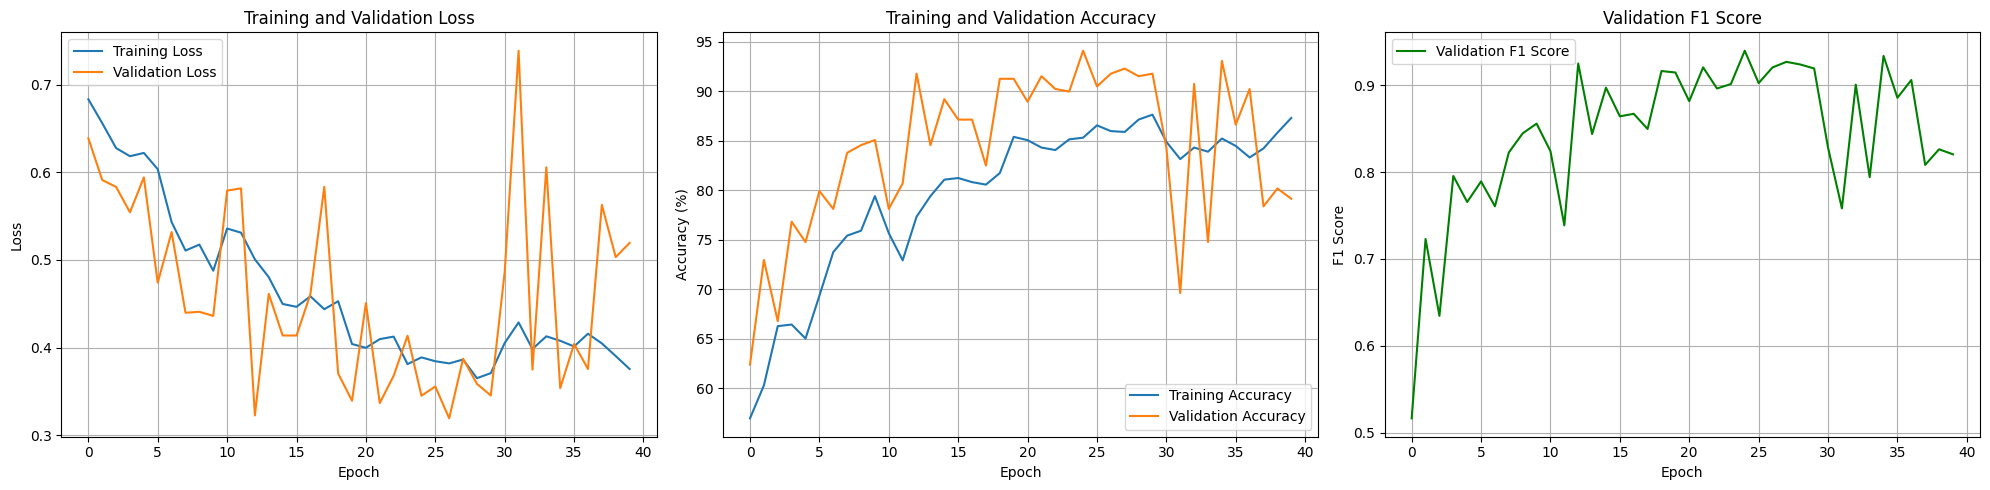

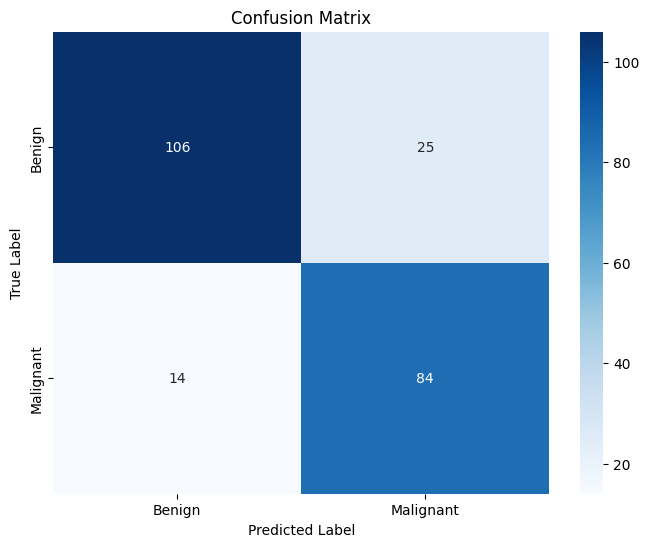

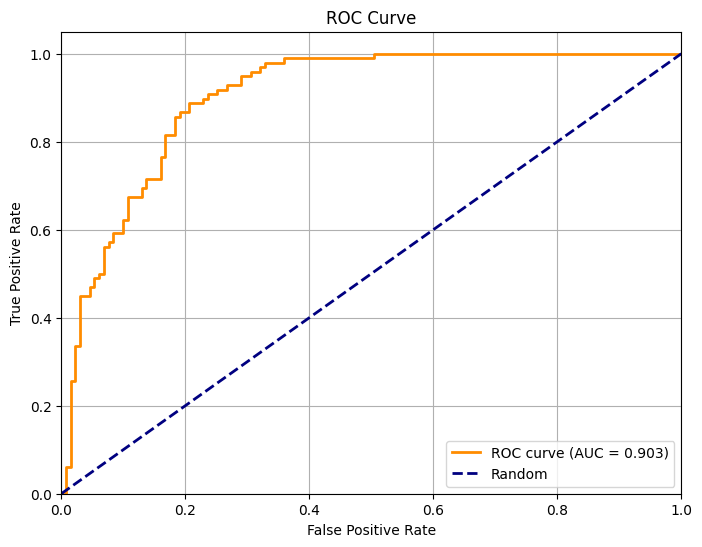

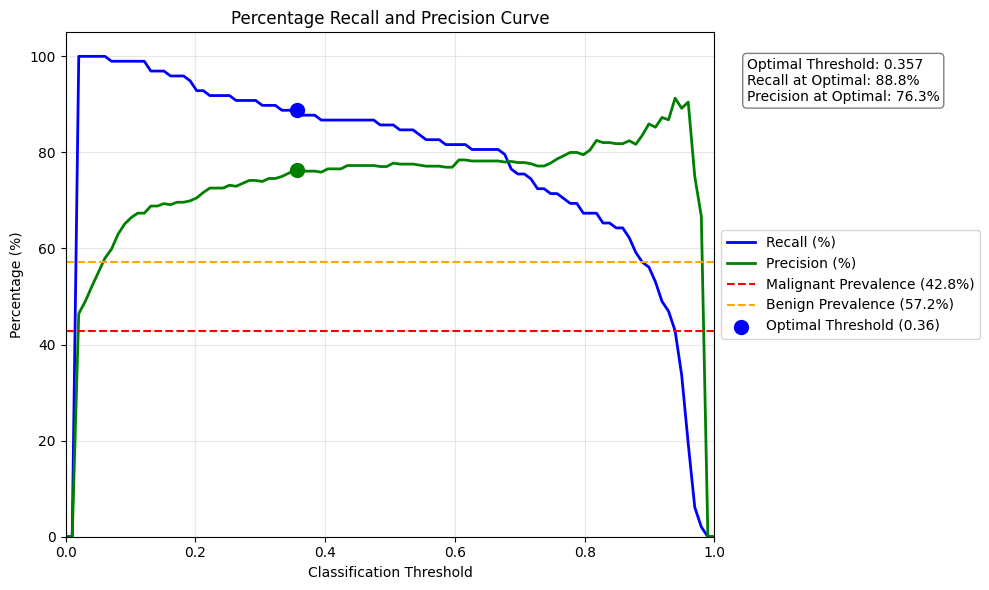

All performance plots generated successfully

STEP 7: EXPLAINABLE AI (XAI) ANALYSIS
--------------------------------------------------
Generating model explanations using 5 different techniques:
  1. Saliency Maps - Basic gradient-based explanations
  2. Grad-CAM - Class activation mapping
  3. Integrated Gradients - Path-based attributions
  4. SHAP - Game theory-based explanations
  5. LIME - Local interpretable explanations
Creating XAI-compatible model...

Processing Sample 1
True Label: Benign
Predicted: Benign
Confidence: 0.8048
Computing Saliency Map...
✓ Saliency completed
Computing Grad-CAM...
✓ Grad-CAM completed
Computing Integrated Gradients...
✓ Integrated Gradients completed
Computing SHAP...
✓ SHAP completed
Computing LIME...


  0%|          | 0/300 [00:00<?, ?it/s]

LIME computation failed: only length-1 arrays can be converted to Python scalars
✓ LIME completed
Creating visualization...


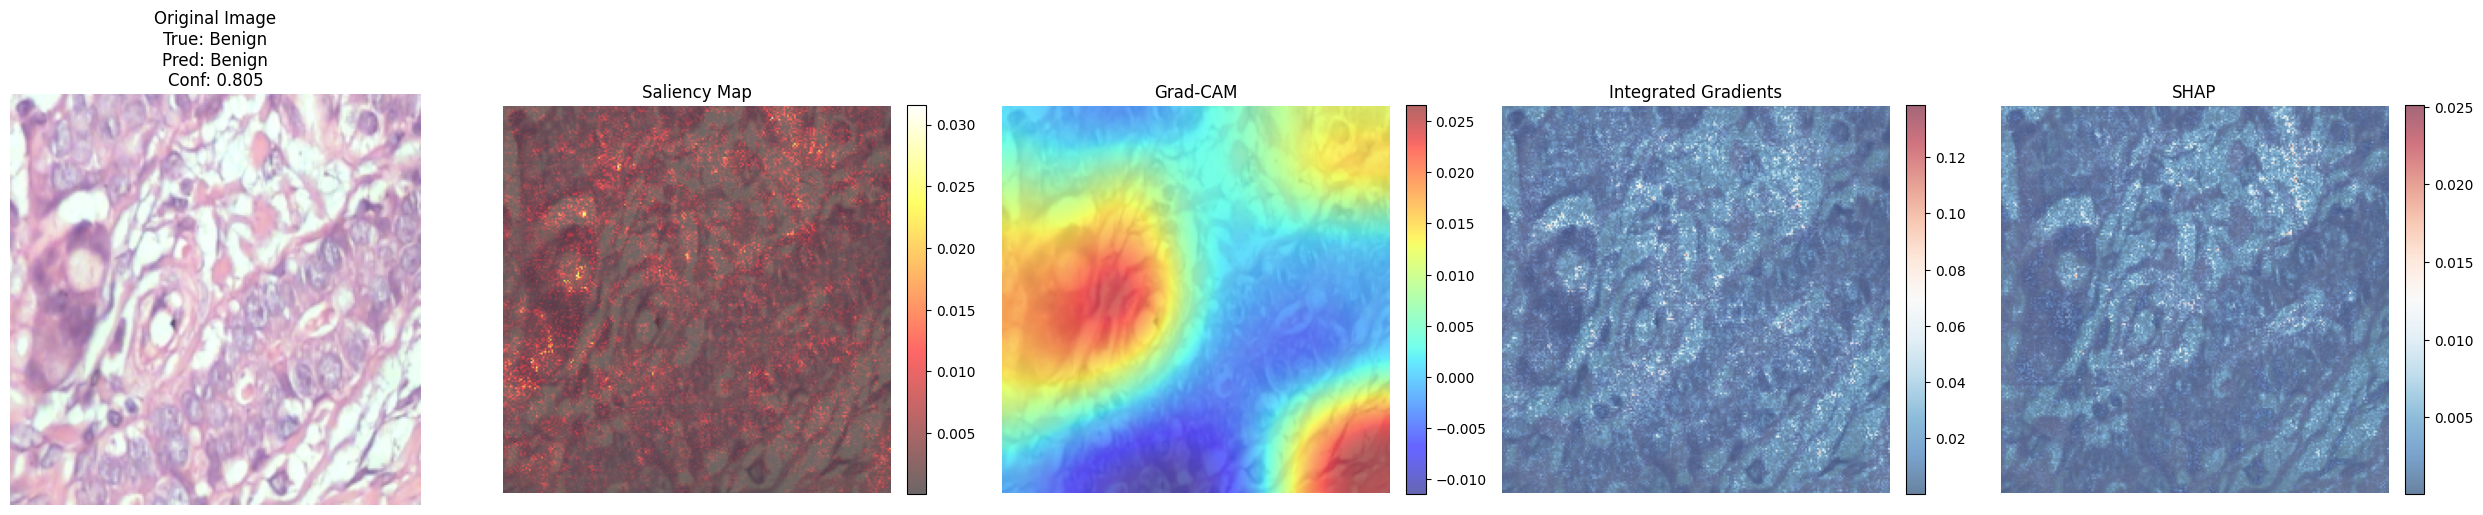

✓ Sample 1 visualization completed
Successfully computed 4/5 XAI techniques

Processing Sample 2
True Label: Benign
Predicted: Benign
Confidence: 0.9790
Computing Saliency Map...
✓ Saliency completed
Computing Grad-CAM...
✓ Grad-CAM completed
Computing Integrated Gradients...
✓ Integrated Gradients completed
Computing SHAP...
✓ SHAP completed
Computing LIME...


  0%|          | 0/300 [00:00<?, ?it/s]

LIME computation failed: only length-1 arrays can be converted to Python scalars
✓ LIME completed
Creating visualization...


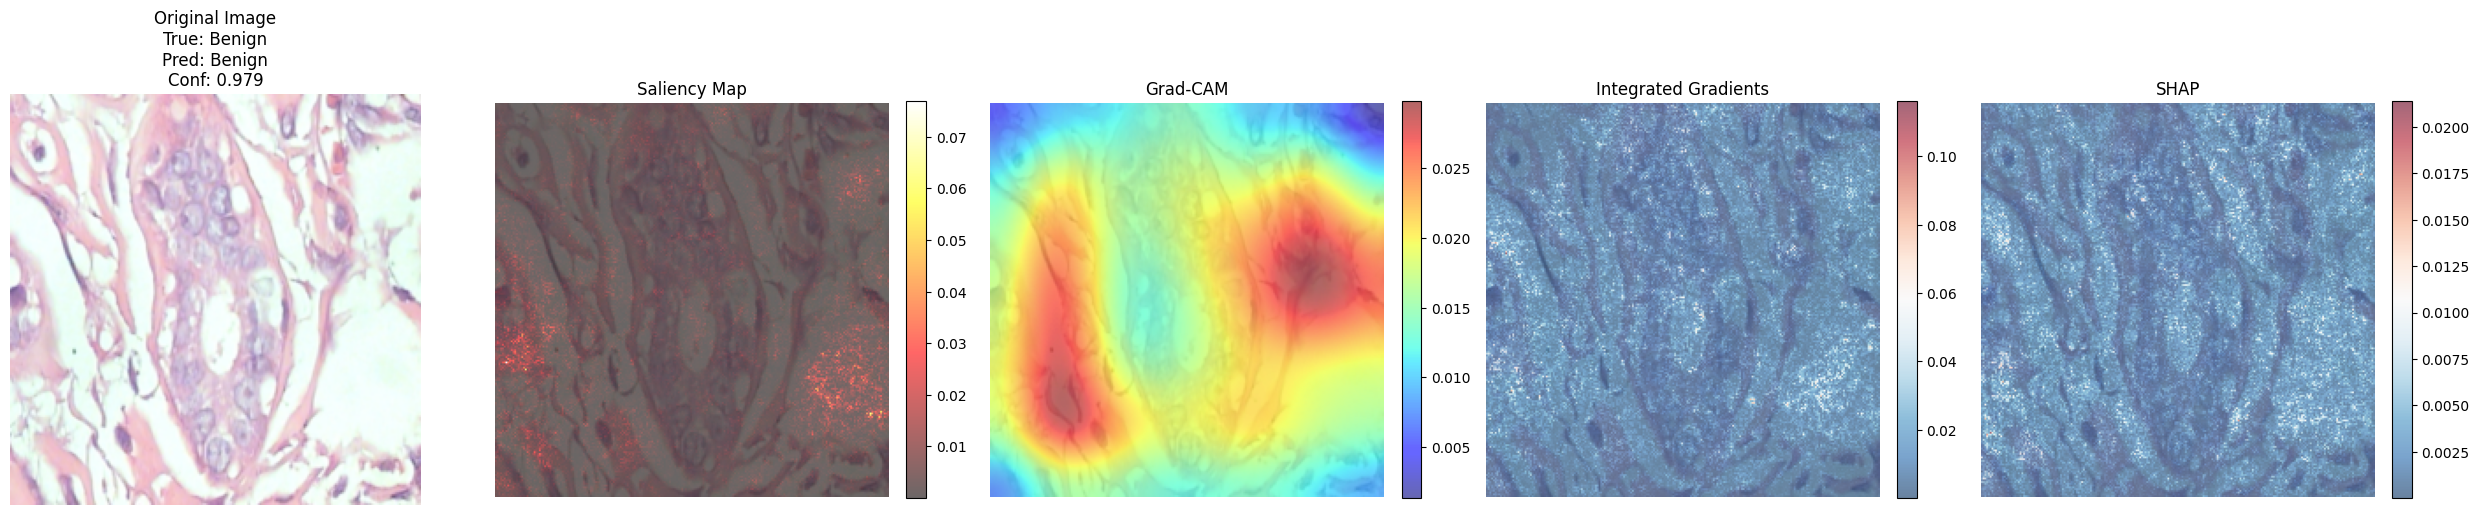

✓ Sample 2 visualization completed
Successfully computed 4/5 XAI techniques

Processing Sample 3
True Label: Benign
Predicted: Benign
Confidence: 0.9909
Computing Saliency Map...
✓ Saliency completed
Computing Grad-CAM...
✓ Grad-CAM completed
Computing Integrated Gradients...
✓ Integrated Gradients completed
Computing SHAP...
✓ SHAP completed
Computing LIME...


  0%|          | 0/300 [00:00<?, ?it/s]

LIME computation failed: only length-1 arrays can be converted to Python scalars
✓ LIME completed
Creating visualization...


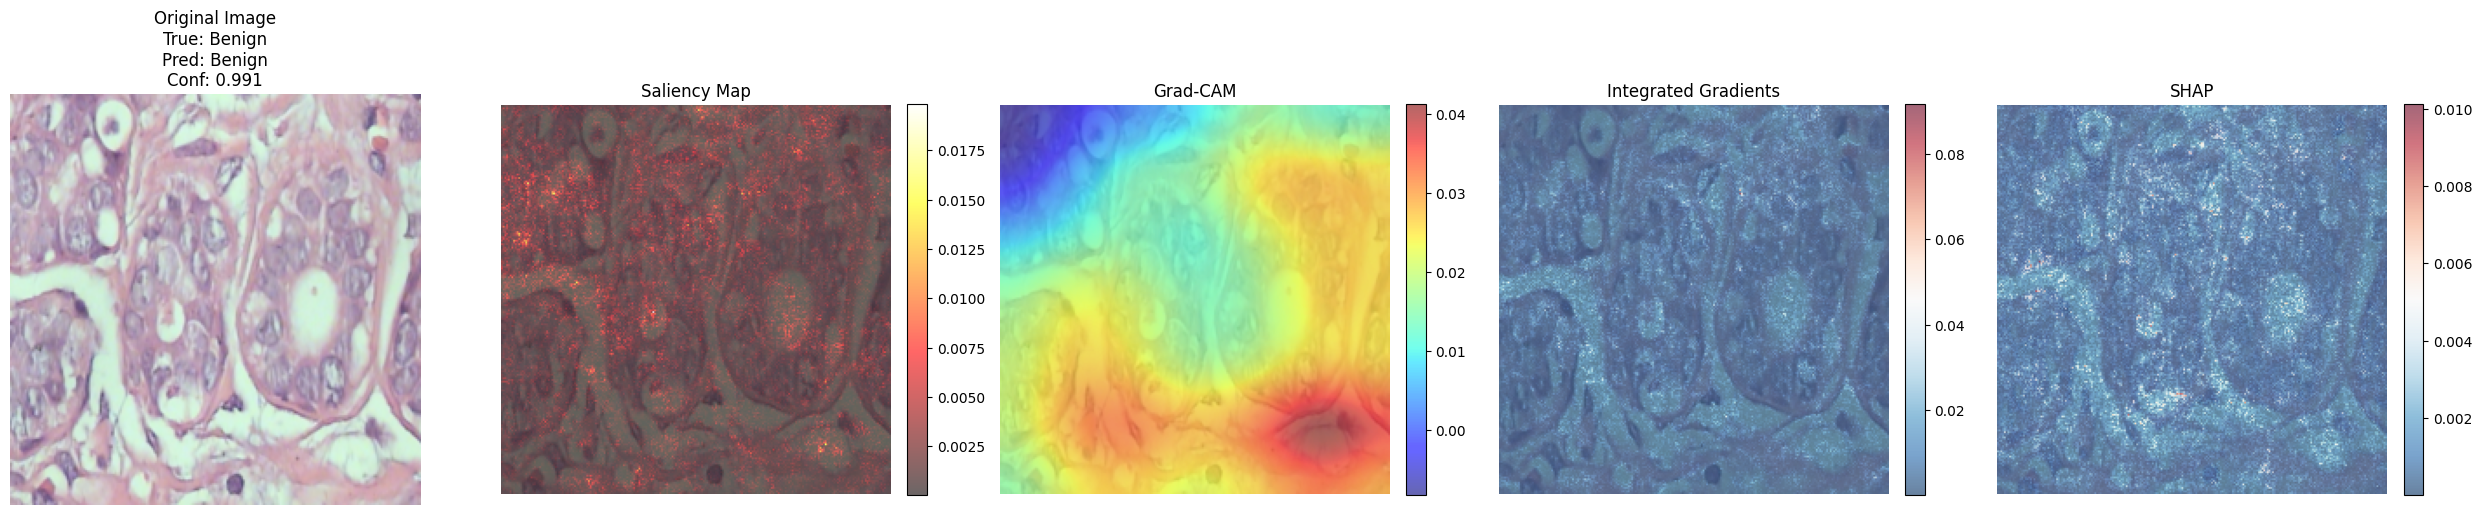

✓ Sample 3 visualization completed
Successfully computed 4/5 XAI techniques

XAI analysis completed successfully!
XAI visualizations saved to: ./xai_results/

STEP 8: SAVING RESULTS
--------------------------------------------------
Comprehensive results saved to: results/breakhis_400x_results_20250723_233555.json
Detailed predictions saved to: results/predictions_400x_20250723_233555.csv

ANALYSIS COMPLETE - FINAL SUMMARY
Dataset: 1820 images (400X magnification)
Model: ResNet-50 with transfer learning
Test Accuracy: 0.8297 (82.97%)
Test F1-Score: 0.8116
Test AUC-ROC: 0.9031
XAI Analysis: Completed with 5 explanation techniques
Results saved to: ./results/
Plots saved to: ./plots/
XAI visualizations: ./xai_results/
TensorBoard logs: logs/breakhis_400X_20250723-231722
   Run: tensorboard --logdir=logs/breakhis_400X_20250723-231722

All analyses completed successfully!

Performing cleanup...
TensorBoard writer closed
GPU cache cleared
Program execution finished


In [39]:
if __name__ == '__main__':
    print("Starting Advanced BreaKHis Breast Cancer Classification with XAI Analysis - 400X Magnification")
    print("="*80)

    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    try:
        # Step 1: Dataset Loading and Preprocessing
        print("\nSTEP 1: DATASET LOADING AND PREPROCESSING")
        print("-"*50)

        print("Loading BreaKHis dataset...")
        df = load_dataset(path)

        if len(df) == 0:
            raise ValueError("No images found in the dataset. Please check the dataset path.")

        # Filter for 400X magnification only for better consistency
        df_400x = df[df['magnification'] == '400X']
        if len(df_400x) == 0:
            print("No 400X magnification images found, using all magnifications")
            df_filtered = df
            magnification_used = 'all'
        else:
            df_filtered = df_400x
            magnification_used = '400X'

        print(f"Dataset loaded successfully:")
        print(f"  Total images: {len(df_filtered)}")
        print(f"  Magnification: {magnification_used}")
        print(f"  Benign samples: {len(df_filtered[df_filtered['label'] == 0])}")
        print(f"  Malignant samples: {len(df_filtered[df_filtered['label'] == 1])}")

        # Create patient-level splits to avoid data leakage
        print("\nCreating patient-level data splits...")
        train_df, val_df, test_df = create_patient_level_split(df_filtered)

        print(f"Patient-level splits created:")
        print(f"  Train: {len(train_df)} images from {len(train_df['patient_id'].unique())} patients")
        print(f"  Validation: {len(val_df)} images from {len(val_df['patient_id'].unique())} patients")
        print(f"  Test: {len(test_df)} images from {len(test_df['patient_id'].unique())} patients")

        # Step 2: Data Preparation
        print("\nSTEP 2: DATA PREPARATION")
        print("-"*50)

        # Get enhanced transforms with RandAugment
        train_transforms, val_transforms, tta_transforms = get_transforms()
        print("Data augmentation transforms configured")

        # Create datasets
        train_dataset = BreaKHisDataset(train_df['image_path'].values, train_df['label'].values, transform=train_transforms)
        val_dataset = BreaKHisDataset(val_df['image_path'].values, val_df['label'].values, transform=val_transforms)
        test_dataset = BreaKHisDataset(test_df['image_path'].values, test_df['label'].values, transform=val_transforms)

        # Create balanced samplers to handle class imbalance
        train_sampler = create_balanced_sampler(train_df['label'].values)
        val_sampler = create_balanced_sampler(val_df['label'].values)

        # Create optimized data loaders
        batch_size = 32 if torch.cuda.is_available() else 16
        num_workers = min(4, os.cpu_count())

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                num_workers=num_workers, pin_memory=torch.cuda.is_available())
        val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler,
                              num_workers=num_workers, pin_memory=torch.cuda.is_available())
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                num_workers=num_workers, pin_memory=torch.cuda.is_available())

        print(f"Data loaders created:")
        print(f"  Batch size: {batch_size}")
        print(f"  Num workers: {num_workers}")
        print(f"  Train batches: {len(train_loader)}")
        print(f"  Validation batches: {len(val_loader)}")
        print(f"  Test batches: {len(test_loader)}")

        # Step 3: Model Initialization
        print("\nSTEP 3: MODEL INITIALIZATION")
        print("-"*50)

        model = create_resnet_model(num_classes=2, dropout_rate=0.5)
        print(f"ResNet-50 model initialized and moved to {device}")

        # Calculate model parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"  Total parameters: {total_params:,}")
        print(f"  Trainable parameters: {trainable_params:,}")

        # Setup logging
        logger = None
        if TENSORBOARD_AVAILABLE:
            timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
            log_dir = f"logs/breakhis_{magnification_used}_{timestamp}"
            os.makedirs(log_dir, exist_ok=True)
            writer = SummaryWriter(log_dir)
            logger = {'type': 'tensorboard', 'logger': writer}
            print(f"TensorBoard logging enabled: {log_dir}")

        # Step 4: Model Training
        print("\nSTEP 4: MODEL TRAINING")
        print("-"*50)

        training_config = {
            'num_epochs': 50,
            'learning_rate': 1e-4,
            'use_mixed_precision': torch.cuda.is_available(),
            'magnification': magnification_used
        }

        print(f"Training configuration:")
        for key, value in training_config.items():
            print(f"  {key}: {value}")

        model, train_losses, val_losses, train_accuracies, val_accuracies, val_f1_scores = train_model(
            model, train_loader, val_loader, logger=logger, **training_config
        )

        print("Training completed successfully!")

        # Step 5: Model Evaluation
        print("\nSTEP 5: MODEL EVALUATION")
        print("-"*50)

        # Load best model
        best_model_path = f"./models/best_resnet50_{magnification_used}.pth"
        if os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path, map_location=device))
            print("Best model loaded for evaluation")
        else:
            print("Using current model state for evaluation")

        # Evaluate with error handling
        print("Evaluating model performance...")
        test_metrics = safe_model_evaluation(model, test_loader)

        if test_metrics is None:
            print("Model evaluation failed")
            exit(1)

        # Display comprehensive results
        print("\nEVALUATION RESULTS:")
        display_metrics(test_metrics)

        # Step 6: Visualization and Plots
        print("\nSTEP 6: GENERATING PERFORMANCE VISUALIZATIONS")
        print("-"*50)

        try:
            generate_all_plots(test_metrics, train_losses, val_losses,
                             train_accuracies, val_accuracies, val_f1_scores)
            print("All performance plots generated successfully")
        except Exception as e:
            print(f"Error generating some plots: {e}")

        # Step 7: XAI Analysis
        print("\nSTEP 7: EXPLAINABLE AI (XAI) ANALYSIS")
        print("-"*50)
        print("Generating model explanations using 5 different techniques:")
        print("  1. Saliency Maps - Basic gradient-based explanations")
        print("  2. Grad-CAM - Class activation mapping")
        print("  3. Integrated Gradients - Path-based attributions")
        print("  4. SHAP - Game theory-based explanations")
        print("  5. LIME - Local interpretable explanations")

        try:
            # Clear GPU cache before XAI analysis
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Run XAI analysis with error handling
            num_xai_samples = min(3, len(test_dataset))
            visualize_all_xai_techniques(model, test_loader, device, num_samples=num_xai_samples)

            print("\nXAI analysis completed successfully!")
            print(f"XAI visualizations saved to: ./xai_results/")

        except Exception as e:
            print(f"\nXAI analysis encountered issues: {e}")
            print("This might be due to:")
            print("  - Insufficient GPU memory")
            print("  - Missing XAI dependencies")
            print("  - Model compatibility issues")

            # Attempt simplified analysis
            try:
                print("\nAttempting simplified XAI analysis...")
                visualize_all_xai_techniques(model, test_loader, device, num_samples=1)
                print("Simplified XAI analysis completed!")
            except Exception as e2:
                print(f"Simplified XAI analysis also failed: {e2}")

        # Step 8: Results Summary and Saving
        print("\nSTEP 8: SAVING RESULTS")
        print("-"*50)

        # Create comprehensive results summary
        results_summary = {
            'experiment_info': {
                'timestamp': datetime.now().isoformat(),
                'device': str(device),
                'magnification': magnification_used,
                'total_runtime_minutes': None  # Could add timing
            },
            'dataset_info': {
                'total_images': len(df_filtered),
                'train_images': len(train_df),
                'val_images': len(val_df),
                'test_images': len(test_df),
                'train_patients': len(train_df['patient_id'].unique()),
                'val_patients': len(val_df['patient_id'].unique()),
                'test_patients': len(test_df['patient_id'].unique()),
                'class_distribution': {
                    'benign': int(len(df_filtered[df_filtered['label'] == 0])),
                    'malignant': int(len(df_filtered[df_filtered['label'] == 1]))
                }
            },
            'model_info': {
                'architecture': 'ResNet-50',
                'num_classes': 2,
                'total_parameters': total_params,
                'trainable_parameters': trainable_params,
                'transfer_learning': True,
                'dropout_rate': 0.5
            },
            'training_info': {
                'num_epochs': len(train_losses),
                'batch_size': batch_size,
                'learning_rate': training_config['learning_rate'],
                'mixed_precision': training_config['use_mixed_precision'],
                'best_val_f1': float(max(val_f1_scores)) if val_f1_scores else None,
                'final_train_acc': float(train_accuracies[-1]) if train_accuracies else None,
                'final_val_acc': float(val_accuracies[-1]) if val_accuracies else None
            },
            'performance_metrics': {
                'accuracy': float(test_metrics['accuracy']),
                'precision': float(test_metrics['precision']),
                'recall': float(test_metrics['recall']),
                'specificity': float(test_metrics['specificity']),
                'f1_score': float(test_metrics['f1']),
                'auc_roc': float(test_metrics['auc_roc']),
                'confusion_matrix': test_metrics['confusion_matrix'].tolist()
            }
        }

        # Save results
        os.makedirs('results', exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        results_file = f"results/breakhis_400x_results_{timestamp}.json"

        with open(results_file, 'w') as f:
            json.dump(results_summary, f, indent=2)

        print(f"Comprehensive results saved to: {results_file}")

        # Save model predictions for further analysis
        predictions_df = pd.DataFrame({
            'image_path': test_df['image_path'].values,
            'true_label': test_metrics['labels'],
            'predicted_label': test_metrics['predictions'],
            'prediction_probability': test_metrics['probabilities'],
            'patient_id': test_df['patient_id'].values
        })
        predictions_file = f"results/predictions_400x_{timestamp}.csv"
        predictions_df.to_csv(predictions_file, index=False)
        print(f"Detailed predictions saved to: {predictions_file}")

        # Final Summary
        print("\nANALYSIS COMPLETE - FINAL SUMMARY")
        print("="*80)
        print(f"Dataset: {len(df_filtered)} images ({magnification_used} magnification)")
        print(f"Model: ResNet-50 with transfer learning")
        print(f"Test Accuracy: {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
        print(f"Test F1-Score: {test_metrics['f1']:.4f}")
        print(f"Test AUC-ROC: {test_metrics['auc_roc']:.4f}")
        print(f"XAI Analysis: Completed with 5 explanation techniques")
        print(f"Results saved to: ./results/")
        print(f"Plots saved to: ./plots/")
        print(f"XAI visualizations: ./xai_results/")

        if logger and logger['type'] == 'tensorboard':
            print(f"TensorBoard logs: {log_dir}")
            print(f"   Run: tensorboard --logdir={log_dir}")

        print("\nAll analyses completed successfully!")

    except KeyboardInterrupt:
        print("\n\nAnalysis interrupted by user")

    except Exception as e:
        print(f"\nFATAL ERROR occurred: {e}")
        print("\nTroubleshooting suggestions:")
        print("1. Verify dataset path and structure")
        print("2. Check available GPU/CPU memory")
        print("3. Ensure all required libraries are installed:")
        print("   pip install torch torchvision captum shap lime scikit-image")
        print("4. Check file permissions for saving results")
        print("5. Try reducing batch_size if memory issues occur")

        import traceback
        print("\nFull error traceback:")
        traceback.print_exc()

    finally:
        # Cleanup operations
        print("\nPerforming cleanup...")

        # Close tensorboard writer
        if 'logger' in locals() and logger and logger['type'] == 'tensorboard':
            try:
                logger['logger'].close()
                print("TensorBoard writer closed")
            except:
                pass

        # Clear GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            print("GPU cache cleared")

        # Final memory cleanup
        import gc
        gc.collect()

        print("Program execution finished")
        print("="*80)